In [1]:
import Pkg; Pkg.activate("."); Pkg.instantiate(verbose=true)

  Activating project at `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs`


In [2]:
Pkg.status()

      Status `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs/Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [b0b7db55] ComponentArrays v0.13.12
  [8f4d0f93] Conda v1.8.0
  [aae7a2af] DiffEqFlux v1.54.0
  [0c46a032] DifferentialEquations v7.7.0
  [31c24e10] Distributions v0.25.91
  [587475ba] Flux v0.13.16
  [f6369f11] ForwardDiff v0.10.35
  [bd48cda9] GraphRecipes v0.5.12
  [86223c79] Graphs v1.8.0
  [7073ff75] IJulia v1.24.0
  [4138dd39] JLD v0.13.3
  [b964fa9f] LaTeXStrings v1.3.0
  [b2108857] Lux v0.4.53
  [429524aa] Optim v1.7.5
  [7f7a1694] Optimization v3.14.1
  [253f991c] OptimizationFlux v0.1.4
  [91a5bcdd] Plots v1.38.11
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
  [731186ca] RecursiveArrayTools v2.38.3
  [1ed8b502] SciMLSensitivity v7.31.0
  [e88e6eb3] Zygote v0.6.61


In [3]:
using DiffEqFlux
using SciMLSensitivity
using Optimization
using DifferentialEquations.StochasticDiffEq
using DifferentialEquations.DiffEqCallbacks
using DifferentialEquations.DiffEqNoiseProcess
using Statistics, LinearAlgebra, Random
using Plots
using DifferentialEquations.DiffEqBase.EnsembleAnalysis
using BenchmarkTools
using LaTeXStrings
using Printf # print formatting
using ForwardDiff
using Graphs
using GraphRecipes
using RecursiveArrayTools
using Lux
using Lux.NNlib # to get access to additional activation functions
using Statistics # for covariance from sample

In [217]:
vcat(u_0, u_0)

4-element Vector{Float32}:
 100.0
  20.0
 100.0
  20.0

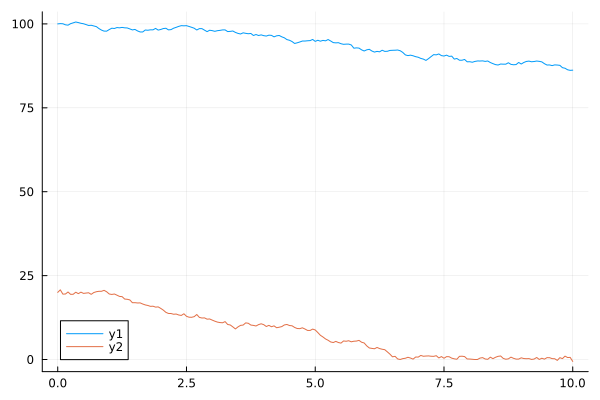

In [221]:
# set up problem: initial conditions, params, solver hyperparams
# make sure you match precisions, i.e., Float32 single precision
datasize = 201
tspan = (0.0f0, 10.0f0)
tsteps = range(tspan[1], tspan[2], length = datasize)
NOISE_STRUCT = zeros(Float32,2,4)
u_0 = Float32[
    100.0,
    20.0
]
u_0_OP_norm = vcat(u_0, u_0)

# produce NN for rates expressions in drift and diffusion functions of SDE
function ratestodrift(u, p, t)
    R1,R2,R3,R4 = ratesmodel(u,rebuild(p),st)[1]
    return [
        R4-(R1+R3),
        R3-(R2+R4)
    ]
end

function ratestodiff(u, p, t)
    R1_r,R2_r,R3_r,R4_r = ratesmodel(u,rebuild(p),st)[1].^(1/2)
    return [
        -R1_r 0.0 -R3_r R4_r;
        0.0 -R2_r R3_r -R4_r
    ]
end

# generate feedforward NN, probably better to not use ReLU at final layer to enforce positive outputs, has zero gradients
# try softplus instead which still maps negative elements to upper half plane, need to import NNlib for it: 
# https://stackoverflow.com/questions/49982438/how-to-restrict-the-output-of-neural-network-to-be-positive-in-python-keras
# ratesmodel = Lux.Chain(Lux.Dense(2, 16, relu), Lux.Dense(16, 4, relu));
# per Prabhat suggestion, eliminate all ReLU! turn all to some other activation, e.g., softplus
# ratesmodel = Lux.Chain(Lux.Dense(2, 16, relu), Lux.Dense(16, 4, softplus));
# it seems like the x3 output of ratesmodel is never large, perhaps info is lost early in training due to negative real line
# mapping to near zero, try tanh (symmetric odd about zero, has equal representation, but will be slower training) in middle layer
# but keep softplus on output to maintain positivity
# ratesmodel = Lux.Chain(Lux.Dense(2, 16, softplus), Lux.Dense(16, 4, softplus));
# now non-dimensionalize the inputs by their u0 magnitude to speed up training
# doing so for the output layer will require you to know the dependencies of the rxn laws on inputs, here we assume this is known
# ratesmodel = Lux.Chain(Lux.Dense(2, 16, tanh), Lux.Dense(16, 4, softplus));

# output normalization looks like X1,X2,X1,X2 since this is what we may consider the outputs to depend on
# actually produces really large gradients, not so useful yet? need to figure out better ways to normalize
# ratesmodel = Lux.Chain(x->x ./ u_0, Lux.Dense(2, 16, tanh), Lux.Dense(16, 4, softplus), x->x .* u_0_OP_norm)
ratesmodel = Lux.Chain(Lux.Dense(2, 16, tanh), Lux.Dense(16, 4, softplus))
p_nn, st = Lux.setup(Xoshiro(0), ratesmodel)

# positive test
ratesmodel(u_0,p_nn,st)

# can destructure params and Restructure them out of p_nn
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)

# reflecting condition, helps stabilize ensemble results
# see https://stackoverflow.com/questions/69049991/simulating-a-reflecting-boundary-sdeproblem
function affect!(integrator)
    if integrator.u[2] < 0
        integrator.u[2] = -integrator.u[2]
    end
end
condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,false))
cbs = CallbackSet(cb_reflect)

# need to implement functions to recover parameters from Lux structures
prob = SDEProblem(
    ratestodrift,
    ratestodiff,
    u_0,
    tspan,
    Flux.destructure(p_nn)[1],
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

sol = solve(prob, EM(), dt=0.05, saveat=0.05; sensealg=TrackerAdjoint(), save_everystep=false)
plot(sol.t, Array(sol)')# , xlim = (0.0,10.0), ylim = (0,100))

# Positive Test: adjoint on the SDE solve using `sensealg`
## Solution: remove `save_everystep=false`

In [222]:
function loss_neuralsde(p,u=u_0)
    dt = 0.05
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT, callback=cbs)
    sol = solve(prob, EM(), dt = dt, saveat = dt; sensealg=BacksolveAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true)) #BacksolveAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true))
    loss = sum(abs2,sol[:,:])
    return loss, sol
end

res_p = loss_neuralsde(flat,u_0)[2]
res = Zygote.gradient(p->loss_neuralsde(p,u_0)[1],flat)[1]
res2 = ForwardDiff.gradient(p -> loss_neuralsde(p, u_0)[1], flat)

116-element Vector{Float32}:
       0.0
     577.12463
       0.0
    -200.8794
       0.0
       0.0
       0.0
       0.0
   -1869.3046
       0.0
       0.0
       0.0
       0.0
       ⋮
  134840.61
    6315.306
   18305.969
  -64818.934
 -151331.19
   -4206.787
  -13402.578
   65753.945
 -151331.19
   -4206.787
  -13402.578
   65753.945

In [197]:
length(res_p.t)

201

# Get Ground Truth Moments

In [164]:
function trueSDEfunc!(du,u,p,t)
    @inbounds begin
        # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[2]
        R3 = exp(p[3])*u[1]
        R4 = exp(p[4])*u[2]
        du[1] = R4-R1-R3
        du[2] = R3-R2-R4
    end
end

function true_noise_func!(du,u,p,t)
    @inbounds begin
        # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[2]
        R3 = exp(p[3])*u[1]
        R4 = exp(p[4])*u[2]
        du[1, 1] = -sqrt(R1)
        du[1, 3] = -sqrt(R3)
        du[1, 4] = sqrt(R4)
        du[2, 2] = -sqrt(R2)
        du[2, 3] = sqrt(R3)
        du[2, 4] = -sqrt(R4)
    end
end

# new IC
u_0 = Float64[
    100.0,
    20.0
]
p_true = log.(Float64[
    0.1,
    0.2,
    0.2,
    0.5
])

# ground truth for two-pool model using ensemble of 100000 trajectories
# use callbacks from before, save_position = (false,false)
prob_truesde = SDEProblem(
    trueSDEfunc!,
    true_noise_func!,
    u_0,
    tspan,
    p_true,
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

# do ensemble of N unique SDE solves (make sure seed != 1)
N = 100000
ensembleprob = EnsembleProblem(prob_truesde)
sol_true = solve(ensembleprob, EM(), dt=0.05, saveat = 0.05, trajectories = N)

# parse to remove failed simulations
parsed_sol_cb = [(sol_true.u[i].retcode != ReturnCode.Success ? nothing : sol_true.u[i]) for i in 1:length(sol_true.u)]
parsed_sol_cb = parsed_sol_cb[parsed_sol_cb.!=nothing]
truemean_cb = mean(parsed_sol_cb)[:,:]
truevar_cb = var(parsed_sol_cb)[:, :]
VA_true = VectorOfArray(parsed_sol_cb) # vector of arrays upgrades indexing into array capabilities for noobs like me
truecov_cb = [Statistics.cov(VA_true[1,i,:],VA_true[2,i,:]) for i in 1:length(sol_true[1].t)] # touches each time point's state distributions

# number/proportion of failed simulations
println("$(N-length(parsed_sol_cb)) failed simulations, or $(1-length(parsed_sol_cb)/N)")

0 failed simulations, or 0.0


In [85]:
length(sol[1].t)

201

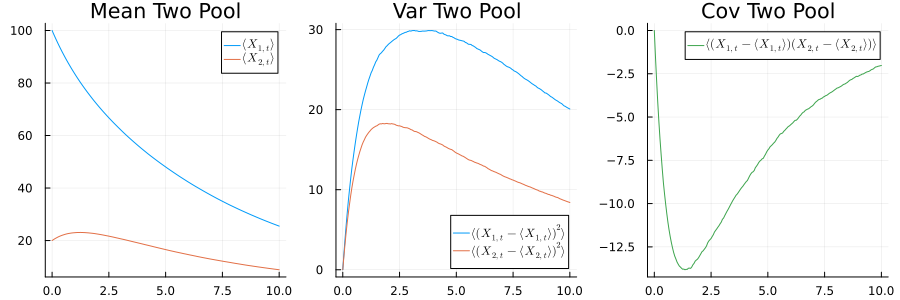

In [175]:
# plot ground truth, i.e., total 5 moments of data
p_twopool_mean = plot(
    sol_true.u[1].t,
    truemean_cb',
    title = "Mean Two Pool", 
    label = [L"\langle X_{1,t} \rangle" L"\langle X_{2,t} \rangle"]
) # two time series here
p_twopool_var = plot(
    sol_true.u[1].t,
    truevar_cb', 
    title = "Var Two Pool",
    label = [L"\langle (X_{1,t} - \langle X_{1,t} \rangle)^2 \rangle" L"\langle (X_{2,t} - \langle X_{2,t} \rangle)^2 \rangle"]
) # two time series here
p_twopool_cov = plot(
    sol_true.u[1].t,
    truecov_cb,
    title = "Cov Two Pool",
    label = L"\langle (X_{1,t} - \langle X_{1,t} \rangle) (X_{2,t} - \langle X_{2,t} \rangle) \rangle",
    legend = :topright,
    color = 3
) # one time series here

plot(
    p_twopool_mean,
    p_twopool_var,
    p_twopool_cov,
    layout = (1,3),
    size = (900,300)
)

# Training on non-zero ICs

In [204]:
# w/o ensembling, more costly to compute when doing back prop
# need large n to get reliable covariance estimates for a batch of simulations
function loss_neuralsde2(p,u=u_0,n=1000)
    dt = 0.05
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT, callback=cbs)
    res = map(
        (x->solve(prob, EM(), dt = dt, saveat = dt; sensealg=InterpolatingAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true))),
        [u_0 for i in 1:n]
    )
    VA = VectorOfArray(res)
    arr = convert(Array,VA)
    means = mean(arr, dims = 3)
    vars = var(arr, dims = 3, mean = means)
    covs = [Statistics.cov(VA[1,i,:],VA[2,i,:]) for i in 1:length(VA[1,:,1])]

    # elastic net, but also put the moments in the same magnitude, i.e., abs instead of abs2 for variances
    # this will also decrease the magnitude of your gradients to make training smoother!
    loss = sum(abs2, truemean_cb .- means) + sum(abs, truevar_cb .- vars) + sum(abs, truecov_cb .- covs) # + 1.0 * sum(abs2, p) + 1.0 * sum(abs, p) # elastic net without hyperparameters optimized
    
    return loss
end

# manipulations of p_nn to get right structure and to train on the correct loss function
n=2
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)
# test_loss = loss_neuralsde2(flat)
# res = Zygote.gradient(p->loss_neuralsde2(p,u_0,n),flat)[1] # was not working at all
res = ForwardDiff.gradient(p->loss_neuralsde2(p,u_0,n),flat)

116-element Vector{Float64}:
      0.0
    146.5421207037973
      0.0
    -58.130157935001314
      0.0
      0.0
      0.0
      0.0
   -815.3791730452378
      0.0
      0.0
      0.0
      0.0
      ⋮
  75787.5988052666
  -7695.651068693438
  17872.423895326236
 -42174.466498139926
 -77647.57294928127
   7483.573970573263
  -9638.072867092103
  30807.434765337028
 -77647.57294928127
   7483.573970573263
  -9638.072867092103
  30807.434765337028

In [209]:
# w/ ensembling + will be much easier to parallelize for multi-node computing, ensembling courtesy of Nathan Stover
function loss_neuralsde3(p,u=u_0,n=1000)
    dt = 0.05
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT, callback=cbs)
    ensembleprob = EnsembleProblem(prob)
    sols = solve(
        ensembleprob,
        EM(), 
        dt=dt, 
        saveat = dt, 
        trajectories = n;
        sensealg=InterpolatingAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true)
    )
    means = mean(sols, dims = 3)[:, :]
    vars = var(sols, dims = 3)[:, :]
    covs = [Statistics.cov(sols[1,i,:],sols[2,i,:]) for i in 1:length(sols[1,:,1])]
    
    loss = sum(abs2, truemean_cb .- means) + sum(abs, truevar_cb .- vars) + sum(abs, truecov_cb .- covs)
    return loss
end

# manipulations of p_nn to get right structure and to train on the correct loss function
n=2
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)
test_loss = loss_neuralsde3(flat)
# res = Zygote.gradient(p->loss_neuralsde3(p,u_0,n),flat)[1] # was not working at all
res = ForwardDiff.gradient(p->loss_neuralsde3(p,u_0,n),flat)

116-element Vector{Float64}:
      0.0
    167.34285913109312
      0.0
    -64.37694473910973
      0.0
      0.0
      0.0
      0.0
   -763.2982673938758
      0.0
      0.0
      0.0
      0.0
      ⋮
  75676.5100437506
  -9270.051080394713
  19403.81122655955
 -49012.963685205825
 -71008.32147290948
   4775.837882671237
 -17549.33465060049
  30601.237634373603
 -71008.32147290948
   4775.837882671237
 -17549.33465060049
  30601.237634373603

In [ ]:
# the ForwardDiff version of this optimization
# https://docs.sciml.ai/Optimization/stable/API/optimization_function/#Optimization.AutoForwardDiff
opt = ADAM(0.001)
losses = []
params_list = []
MAX_ITERS = 2000 # around 20 seconds/iter on KKG comp with tanh + callbacks, so ~5hrs for 500 iters

# save progress of solution, https://docs.sciml.ai/Optimization/stable/API/solve/#CommonSolve.solve-Tuple{OptimizationProblem,%20Any}
function callback(params,loss_val)
    # record round number, loss, and params
    println("Round $(length(params_list)) training loss: $(loss_val)")
    push!(losses,loss_val)
    push!(params_list,params)
    length(params_list) >= MAX_ITERS
end

# First round of training with n = 10
# need to add a slight positive value to the IC to excite non-zero dynamics
t1 = time_ns()
adtype = Optimization.AutoForwardDiff()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde2(x,u_0), adtype)
optprob = Optimization.OptimizationProblem(optf, flat)
result1 = Optimization.solve(optprob, opt, maxiters = MAX_ITERS, callback=callback);
t2 = time_ns()
println("Total time elapsed: $((t2-t1)/1.0e9) seconds")
println("Total time / epoch: $((t2-t1)/1.0e9/MAX_ITERS) seconds")

Round 0 training loss: 453111.71480235056
Round 1 training loss: 455036.8080381227
Round 2 training loss: 457430.8788346929
Round 3 training loss: 446478.3286702829
Round 4 training loss: 456731.81538835494
Round 5 training loss: 445094.79942922055
Round 6 training loss: 443102.21480478835
Round 7 training loss: 433388.0267519618
Round 8 training loss: 438180.3116955233
Round 9 training loss: 442019.77816894226
Round 10 training loss: 433878.30960943195
Round 11 training loss: 432456.5825272158
Round 12 training loss: 431809.18888992316
Round 13 training loss: 435255.2583296017
Round 14 training loss: 424359.848875222
Round 15 training loss: 419339.26568435604
Round 16 training loss: 421535.0764216173
Round 17 training loss: 420142.8421910788
Round 18 training loss: 417371.09062651097
Round 19 training loss: 420723.0969050624
Round 20 training loss: 413139.2524132155
Round 21 training loss: 408794.4847873452
Round 22 training loss: 408010.3436901979
Round 23 training loss: 406368.80871

In [ ]:
# Without ensembling, loss_neuralsde2 + forwarddiff + no nondimensionalization
# Round 0 training loss: 453418.0504395511
# Round 1 training loss: 462522.7751419472
# Round 2 training loss: 444287.04479335964
# Round 3 training loss: 449228.1596051218
# Round 4 training loss: 441237.5707053234
# Total time elapsed: 228.0132093 seconds

# # With Ensembling, loss_neuralsde3 + forwarddiff + no nondimensionalization
# Round 0 training loss: 458726.2071952732
# Round 1 training loss: 452425.5253792036
# Round 2 training loss: 451174.52631210216
# Round 3 training loss: 448231.7828383395
# Round 4 training loss: 449727.0752642476
# Total time elapsed: 1092.5931754 seconds
#

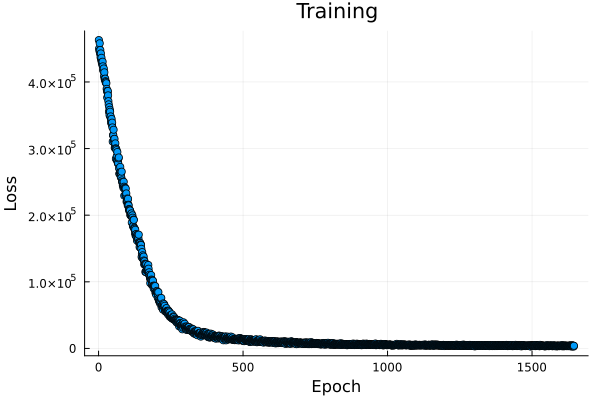

In [227]:
plot(1:MAX_ITERS,losses,ylabel = "Loss", xlabel = "Epoch", markershape=:circle, label="", title="Training")

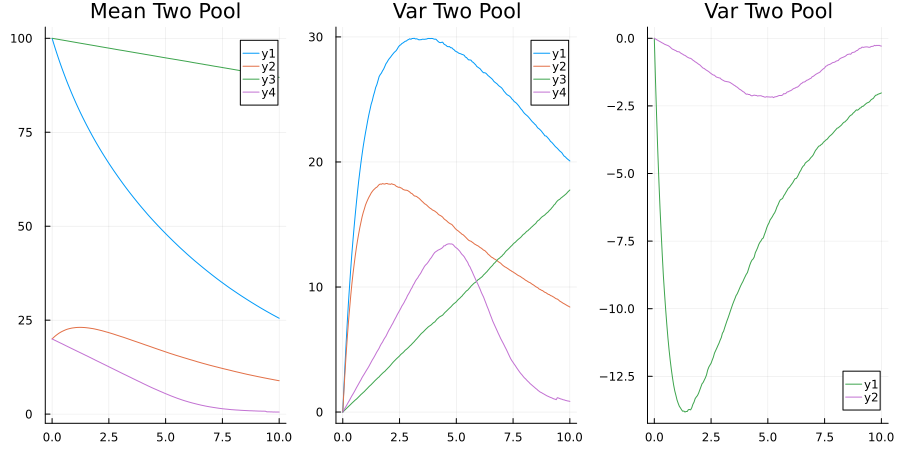

In [229]:
# need to implement functions to recover parameters from Lux structures
prob = SDEProblem(
    ratestodrift,
    ratestodiff,
    u_0,
    tspan,
    Flux.destructure(result1.u)[1],
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)
N = 10000
ensembleprob = EnsembleProblem(prob)
sol = solve(ensembleprob, EM(), dt=0.05, saveat=0.05; trajectories = N, sensealg=InterpolatingAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true))
trained_means = mean(sol, dims = 3)[:,:]
trained_vars = var(sol, dims = 3, mean = trained_means)[:,:]
trained_covs = [Statistics.cov(sol[1,i,:],sol[2,i,:]) for i in 1:length(sol[1,:,1])]

# plot ground truth
p_twopool_mean = plot(sol_true.u[1].t,truemean_cb',title = "Mean Two Pool")
p_twopool_var = plot(sol_true.u[1].t,truevar_cb', title = "Var Two Pool")
p_twopool_cov = plot(sol_true.u[1].t,truecov_cb, title = "Var Two Pool", color = 3)

# plot training results
plot!(p_twopool_mean, sol[1].t, trained_means')
plot!(p_twopool_var, sol[1].t, trained_vars')
plot!(p_twopool_cov, sol[1].t, trained_covs, color = 4)

plot(
    p_twopool_mean,
    p_twopool_var,
    p_twopool_cov,
    layout = (1,3),
    size = (900,450)
)

In [119]:
ratesmodel(u_0,rebuild(result1.u),st)

([33.015316251386395, 48.292424835701524, 2.9768139550025247e-24, 14.304818287707803], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [ ]:
# do ensemble of N unique SDE solves (make sure seed != 1)
N = 100000
ensembleprob = EnsembleProblem(prob_truesde)
sol_true = solve(ensembleprob, EM(), dt=0.05, saveat = 0.05, trajectories = N)

# parse to remove failed simulations
parsed_sol_cb = [(sol_true.u[i].retcode != ReturnCode.Success ? nothing : sol_true.u[i]) for i in 1:length(sol_true.u)]
parsed_sol_cb = parsed_sol_cb[parsed_sol_cb.!=nothing]
truemean_cb = mean(parsed_sol_cb)[:,:]
truevar_cb = var(parsed_sol_cb)[:, :]
VA_true = VectorOfArray(parsed_sol_cb) # vector of arrays upgrades indexing into array capabilities for noobs like me
truecov_cb = [Statistics.cov(VA_true[1,i,:],VA_true[2,i,:]) for i in 1:length(sol_true[1].t)] # touches each time point's state distributions